In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import itertools
import os
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
ds = r'c:\git\barotse\wflow\all_outputs_041\outmaps.nc'
ds = xr.open_dataset(ds)
ds

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 239, time: 729)
Coordinates:
  * time     (time) datetime64[ns] 2001-10-02 2001-10-03 ... 2003-09-30
  * lat      (lat) float32 -10.883333 -10.916667 -10.95 ... -18.85 -18.883333
  * lon      (lon) float32 18.383333 18.416666 18.45 ... 26.283333 26.316668
Data variables:
    crs      |S1 ...
    P        (time, lat, lon) float32 ...
    AET      (time, lat, lon) float32 ...
    run      (time, lat, lon) float32 ...
    qo_riv   (time, lat, lon) float32 ...
    ssf_riv  (time, lat, lon) float32 ...
    ex_us    (time, lat, lon) float32 ...
    ex_ss    (time, lat, lon) float32 ...
    ustore   (time, lat, lon) float32 ...
    SWD      (time, lat, lon) float32 ...
    SWC      (time, lat, lon) float32 ...
    trans    (time, lat, lon) float32 ...
    capflux  (time, lat, lon) float32 ...
    in_ex_s  (time, lat, lon) float32 ...
    inw      (time, lat, lon) float32 ...
    zi       (time, lat, lon) float32 ...
Attributes:
    title:          wflow output mapstack
    institution:    Deltares
    source:         wflow
    history:        2020-06-17T00:11:03.922373
    references:     https://github.com/openstreams/wflow
    Conventions:    CF-1.4
    caseName:       C:\git\barotse\wflow
    runId:          all_outputs_041
    wflow_version:  2019.2.dev9+ge8b26553
    wflow_ini:      wflow_sbm.ini
    wflow_exe:      False

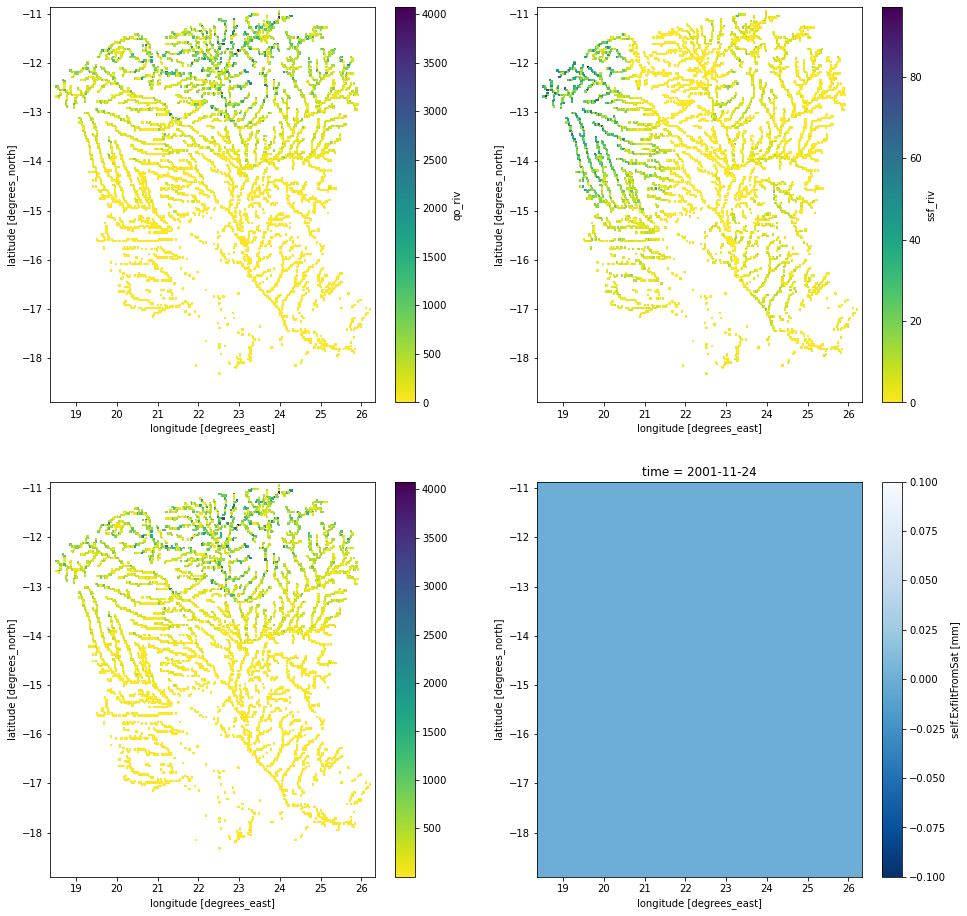

In [3]:
# plot some spatial sums
import numpy as np
f = plt.figure(figsize=(16,16))
ssf = ds['ssf_riv'].sum(dim='time')
qo = ds['qo_riv'].sum(dim='time')
# Inwater = dss[-1]['Inwater'].sum(dim='time')
qo = qo.where(qo+ssf>0)
ssf = ssf.where(qo+ssf>0)
ssf *= ssf>0
qo *= qo>0
# watbal *=watbal<1750
# dss[-1]['wat'][25].plot()
ax1 = plt.subplot(221)
qo.plot(ax=ax1, cmap='viridis_r')

ax2 = plt.subplot(222)
ssf.plot(ax=ax2, cmap='viridis_r')

ax3 = plt.subplot(223)
(qo+ssf).plot(ax=ax3, cmap='viridis_r')

ax4 = plt.subplot(224)
ds['ex_ss'][53].plot(ax=ax4, cmap='Blues_r')
# wb = watbal.mean(dim=('lat', 'lon'))
# wb.plot()

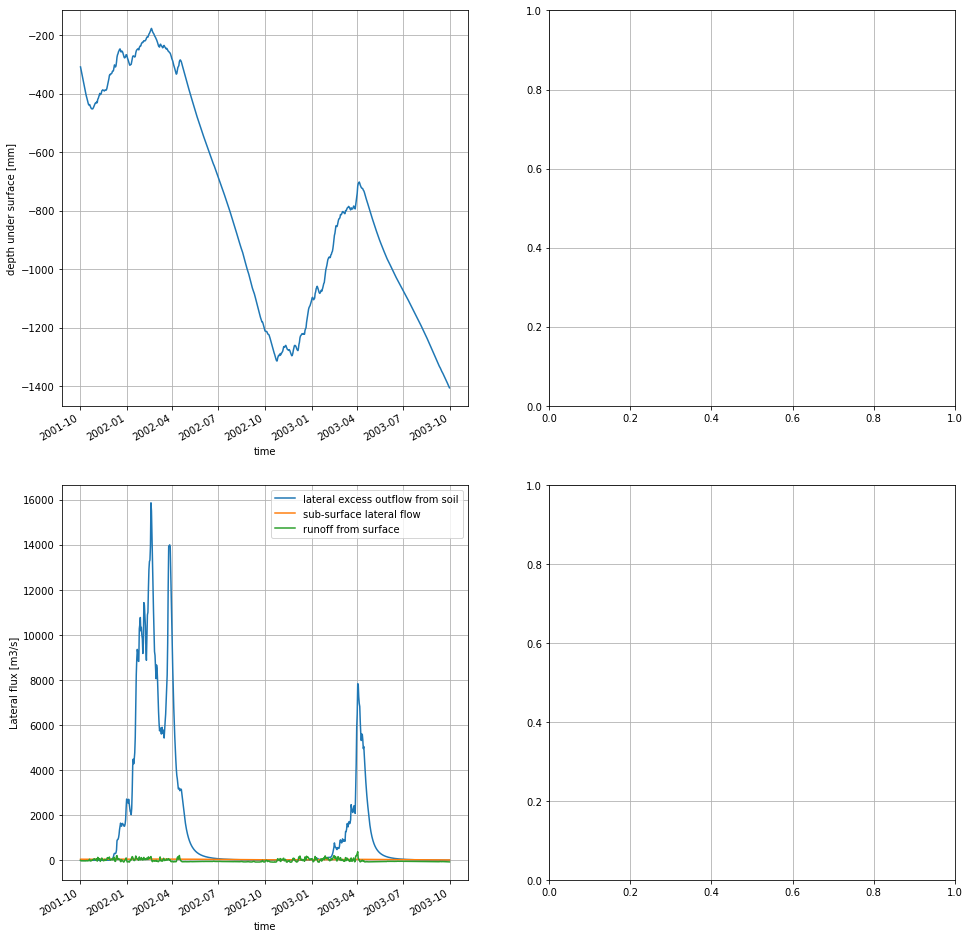

In [4]:
f = plt.figure(figsize=(16, 16))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
surf_area = 5e5 * 1e6 # (about 500,000 km2)

conv_fact = 86400 * surf_area**-1 * 1e3

zi = -ds['zi'].mean(dim=('lat', 'lon'))
transfer = ds['trans'].mean(dim=('lat', 'lon'))
ssf = ds['ssf_riv'].sum(dim=('lat', 'lon'))
qo = ds['qo_riv'].sum(dim=('lat', 'lon'))
inw = ds['inw'].sum(dim=('lat', 'lon'))
surf_runoff = inw-ssf-qo
tot = ssf + qo

# make plots
(zi).plot(ax=ax1, label='Groundwater level')
ax1.set_ylabel('depth under surface [mm]')

#transfer.cumsum().plot(ax=ax2, label='Accumulated transfer from unsaturated to saturated zone')
#ax2.set_ylabel('Transfer [mm]')
#ax2.legend()

qo.plot(ax=ax3, label='lateral excess outflow from soil')
ssf.plot(ax=ax3, label='sub-surface lateral flow')
surf_runoff.plot(ax=ax3, label='runoff from surface')
ax3.set_ylabel('Lateral flux [m3/s]')
ax3.legend()

#inw.plot(ax=ax4, label='Total lateral flow per timestep')
#ax4.set_ylabel('Lateral flux [m3/s]')
#ax4.legend()

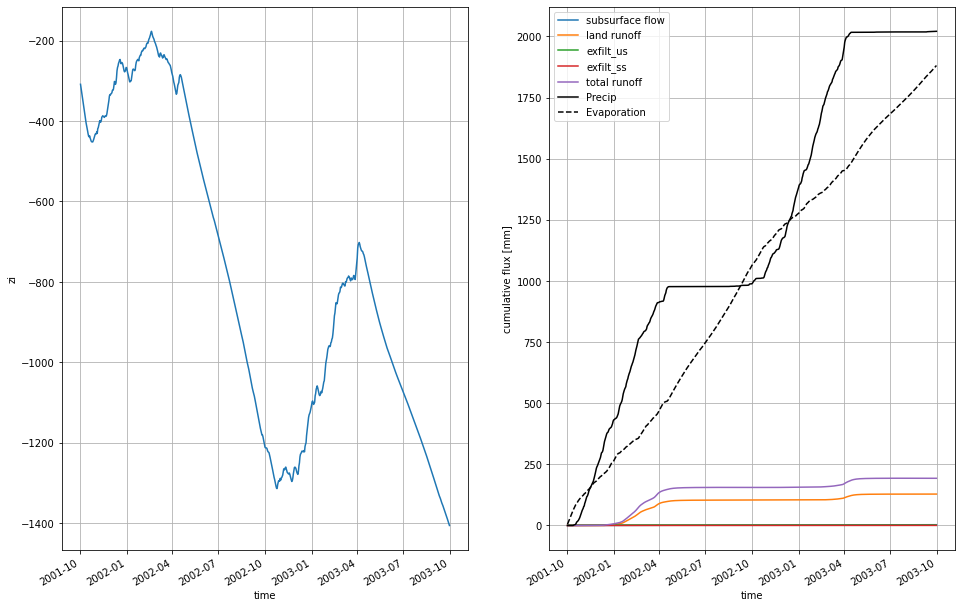

In [6]:
# in mm
f = plt.figure(figsize=(16, 10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
# ax3 = plt.subplot(223)
# ax4 = plt.subplot(224)
ax1.grid()
ax2.grid()
# ax3.grid()
# ax4.grid()
surf_area = 3580 * 3688 # 5e5 * 1e6 # (about 500,000 km2)
conv_fact = 86400 * surf_area**-1 * 1e3 # from m3/s to mm day-1
# ds['swf'][100].plot()
zi = -ds['zi'].mean(dim=('lat', 'lon'))
ssf = ds['ssf_riv'].mean(dim=('lat', 'lon'))*conv_fact  # from m3 s-1 to mm per day
qo = ds['qo_riv'].mean(dim=('lat', 'lon'))*conv_fact  # from m3 s-1 to mm per day
ex_us = ds['ex_us'].mean(dim=('lat', 'lon'))
ex_ss = ds['ex_ss'].mean(dim=('lat', 'lon'))
inw = ds['inw'].mean(dim=('lat', 'lon'))*conv_fact
P = ds['P'].mean(dim=('lat', 'lon'))
AET = ds['AET'].mean(dim=('lat', 'lon'))
# tot = ssf + qo
(zi).plot(ax=ax1)
plt.ylabel('depth under surface [mm]')
ssf.cumsum().plot(ax=ax2, label='subsurface flow')
qo.cumsum().plot(ax=ax2, label='land runoff')
ex_us.cumsum().plot(ax=ax2, label='exfilt_us')
ex_ss.cumsum().plot(ax=ax2, label='exfilt_ss')
inw.cumsum().plot(ax=ax2, label='total runoff')
P.cumsum().plot(ax=ax2, color='k', linestyle='-', label='Precip')
AET.cumsum().plot(ax=ax2, color='k', linestyle='--', label='Evaporation')
plt.ylabel('cumulative flux [mm]')
plt.legend()


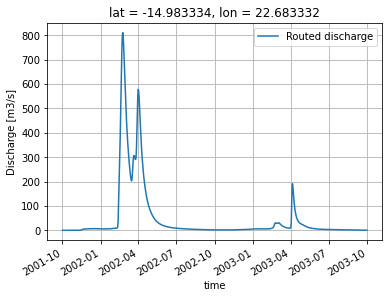

In [7]:
#lon = 23.2  # Lukulu
#lat = -14.337 # Lukulu
#lon = 24.15 # Watopa
#lat = -13.584 # Watopa
#lon = 23.248  # Senanga
#lat = -16.116 # Senanga
#lon = 22.67 # Chavuma
#lat = -13.083 # Chavuma
lon = 22.686 # Kalabo
lat = -14.988 # Kalabo

#ac = ds['accu'].sel(lat=lat, lon=lon, method='nearest')
ts = ds['run'].sel(lat=lat, lon=lon, method='nearest')
#ac.plot(label='instantaneous accumulated flow')
ts.plot(label='Routed discharge')
plt.ylabel('Discharge [m3/s]')
plt.legend()
plt.grid()


In [8]:
ts_month = ts.resample(time='MS').mean()
#ac_month = ac.resample(time='MS').mean()

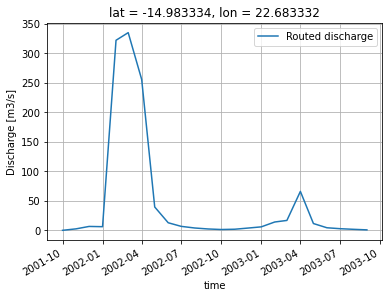

In [9]:
#ac_month.plot(label='Instantaneous accumulated flow')
ts_month.plot(label='Routed discharge')
plt.ylabel('Discharge [m3/s]')
plt.legend()
plt.grid()


Text(0.5, 1.0, 'Upper Zambezi Observed Flows')

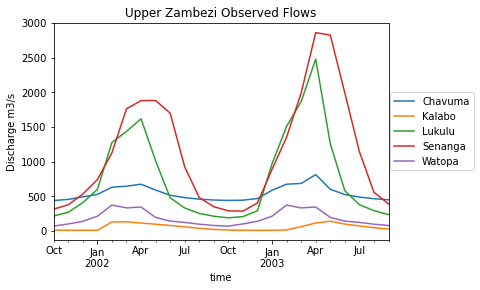

In [10]:
fn = r'c:\zambezi_4km\observed_flow_calib.csv'
df = pd.read_csv(fn, parse_dates=True, index_col=[0])
#df
#df.plot()
monthly=df['2001-10-01':'2003-09-30']
monthly.plot()
#plt.xlabel('Year')
plt.legend(loc='center left', bbox_to_anchor=(0.99, 0.5))
plt.ylabel('Discharge m3/s')
plt.title('Upper Zambezi Observed Flows')
#plt.Figure(figsize=(15, 15))

In [11]:
df.Kalabo

time
2001-10-01      9.217
2001-11-01      8.520
2001-12-01      7.680
2002-01-01      6.840
2002-02-01    126.050
               ...   
NaT               NaN
NaT               NaN
NaT               NaN
NaT               NaN
NaT               NaN
Name: Kalabo, Length: 63, dtype: float64

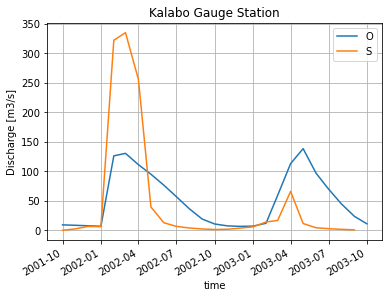

In [12]:
plt.plot(df.Kalabo)
#ts.plot(label='Routed discharge')
ts_month.plot(label='Simulated discharge')
plt.title('Kalabo Gauge Station')
plt.ylabel('Discharge [m3/s]')
plt.legend('OS')
plt.grid()

#sim.plot()
#f = plt.figure(figsize=(15,3))
#plt.show()

In [ ]:
#rms = sqrt(mean_squared_error(df.Lukulu,ts))

rmses = np.sqrt(np.sum((obs-sim)**2))

In [4]:
root_folder = r'c:\git\barotse\wflow'
template = 'all_outputs_{:03d}\outmaps.nc'

KsatVerList = range(1, 2)
RootingDepthList = np.arange(1,4 )
SoilThicknessList = range(1, 4)
rmses = []
mult_Ksat = []
mult_root = []

for n, (KsatVer, RootingDepth, SoilThickness) in enumerate(itertools.product(KsatVerList,
                                                                                 RootingDepthList,
                                                                                 SoilThicknessList,
                                                                                )):
    path = os.path.join(root_folder,template.format(n + 1))
    print(path)
    ds = xr.open_dataset(path)
    mult_Ksat.append(KsatVer)
    #mult_root.append(RootingDepth)
    #mult_thickness.append(SoilThickness)
    
    # extract flows
    # compute rmse
    rmses.append(rmses)
    # put multipliers and rmse in a list
    # add list to a larger list


c:\git\barotse\wflow\all_outputs_001\outmaps.nc
c:\git\barotse\wflow\all_outputs_002\outmaps.nc
c:\git\barotse\wflow\all_outputs_003\outmaps.nc
c:\git\barotse\wflow\all_outputs_004\outmaps.nc
c:\git\barotse\wflow\all_outputs_005\outmaps.nc
c:\git\barotse\wflow\all_outputs_006\outmaps.nc
c:\git\barotse\wflow\all_outputs_007\outmaps.nc
c:\git\barotse\wflow\all_outputs_008\outmaps.nc
c:\git\barotse\wflow\all_outputs_009\outmaps.nc


# ploit results
plt.plot(mult_Ksat, rmses, '.')
plt.xlabel('ksat')
plt.ylabel('rmse')